In [1]:
!pip -q install pandas numpy matplotlib scikit-learn scipy tensorflow

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    precision_recall_curve, f1_score, precision_score, recall_score
)
from sklearn.utils.class_weight import compute_class_weight

from scipy.signal import butter, filtfilt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TF:", tf.__version__)


2025-12-16 00:03:21.596251: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-16 00:03:21.650193: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-16 00:03:23.436947: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TF: 2.20.0


In [2]:
EKG_CSV = "800_ekg.csv"          # aynı klasördeyse
ANN_CSV = "800_annotations.csv" # aynı klasördeyse

assert os.path.exists(EKG_CSV), f"Missing {EKG_CSV}"
assert os.path.exists(ANN_CSV), f"Missing {ANN_CSV}"

ekg = pd.read_csv(EKG_CSV)
ann = pd.read_csv(ANN_CSV)

ekg.columns = [c.strip() for c in ekg.columns]
ann.columns = [c.strip() for c in ann.columns]

display(ekg.head())
display(ann.head())
print("ekg shape:", ekg.shape, "ann shape:", ann.shape)
print("ekg columns:", ekg.columns.tolist())
print("ann columns:", ann.columns.tolist())


,Unnamed: 0,ECG1,ECG2,annotation
0,0,-0.505,0.615,NaN
1,1,-0.495,0.755,NaN
2,2,-0.545,0.805,NaN
3,3,-0.445,0.865,NaN
4,4,-0.275,0.815,NaN


,Unnamed: 0,symbol
0,162,N
1,330,N
2,497,N
3,666,N
4,836,N


ekg shape: (230400, 4) ann shape: (1921, 2)
ekg columns: ['Unnamed: 0', 'ECG1', 'ECG2', 'annotation']
ann columns: ['Unnamed: 0', 'symbol']


In [3]:
# annotations.csv: index column + symbol column
sym_col = None
for c in ann.columns:
    if c.lower() in {"symbol", "annotation", "label"}:
        sym_col = c
        break
if sym_col is None:
    sym_col = ann.columns[-1]

idx_col = None
for c in ann.columns:
    if c == sym_col:
        continue
    if ("unnamed" in c.lower()) or ("index" in c.lower()) or ("sample" in c.lower()) or ("point" in c.lower()):
        idx_col = c
        break
if idx_col is None:
    idx_col = [c for c in ann.columns if c != sym_col][0]

ann2 = ann[[idx_col, sym_col]].rename(columns={idx_col:"sample_index", sym_col:"symbol"})
ann2["sample_index"] = ann2["sample_index"].astype(int)
ann2["symbol"] = ann2["symbol"].astype(str)

# ECG lead columns
lead_cols = [c for c in ekg.columns if c.lower() in {"ecg1","ecg2","lead1","lead2"}]
if len(lead_cols) < 2:
    candidates = [c for c in ekg.columns if not c.lower().startswith("unnamed")]
    num_candidates = [c for c in candidates if pd.api.types.is_numeric_dtype(ekg[c])]
    lead_cols = num_candidates[:2]
lead_cols = lead_cols[:2]

print("lead_cols:", lead_cols)
display(ann2.head())
print("symbol counts:\n", ann2["symbol"].value_counts())


lead_cols: ['ECG1', 'ECG2']


,sample_index,symbol
0,162,N
1,330,N
2,497,N
3,666,N
4,836,N


symbol counts:
 symbol
N    1846
S      30
~      28
|      10
V       6
F       1
Name: count, dtype: int64


In [4]:
FS = 128          # SVDB için yaygın değer, sabit tutuyoruz
PRE_S  = 0.25     # önce
POST_S = 0.45     # sonra

# Binary SVEB: pozitif sınıf
SVEB_POS = {"S", "A", "a", "J"}  # şimdilik; 800'de muhtemelen sadece S var

# Bu task'te drop: non-beat marker (AAMI'de Q yapacağız)
DROP_SYMS = {"~", "|"}


In [5]:
def bandpass(x, fs, low=0.5, high=40.0, order=4):
    ny = 0.5 * fs
    b, a = butter(order, [low/ny, high/ny], btype="band")
    return filtfilt(b, a, x)

def make_windows(ekg_df, ann_df, lead_cols, fs, pre_s, post_s, drop_symbols=None):
    sig = ekg_df[lead_cols].values.astype(np.float32)

    # filtre
    sig_f = np.zeros_like(sig)
    for ch in range(sig.shape[1]):
        sig_f[:, ch] = bandpass(sig[:, ch], fs=fs)

    a = ann_df.copy().sort_values("sample_index")
    if drop_symbols is not None:
        a = a[~a["symbol"].isin(set(drop_symbols))]

    pre  = int(round(pre_s * fs))
    post = int(round(post_s * fs))
    L = pre + post + 1

    idx = a["sample_index"].values

    rr_prev = np.diff(idx, prepend=idx[0]).astype(np.float32) / fs
    rr_next = np.diff(idx, append=idx[-1]).astype(np.float32) / fs
    rr_ratio = np.divide(rr_prev, rr_next, out=np.ones_like(rr_prev), where=rr_next!=0)

    X, R, y_sym = [], [], []
    for i, sidx in enumerate(idx):
        start = sidx - pre
        end   = sidx + post
        if start < 0 or end >= len(sig_f):
            continue
        X.append(sig_f[start:end+1, :])          # (L,2)
        R.append([rr_prev[i], rr_next[i], rr_ratio[i]])  # (3,)
        y_sym.append(a.iloc[i]["symbol"])

    X = np.stack(X).astype(np.float32)
    R = np.array(R, dtype=np.float32)
    y_sym = np.array(y_sym)
    return X, R, y_sym, L

X, R, y_sym, L = make_windows(ekg, ann2, lead_cols, FS, PRE_S, POST_S, drop_symbols=DROP_SYMS)

print("X:", X.shape, "R:", R.shape, "L:", L)
print("symbols:\n", pd.Series(y_sym).value_counts())

y = np.array([1 if s in SVEB_POS else 0 for s in y_sym], dtype=np.int32)
print("binary labels:\n", pd.Series(y).value_counts())


X: (1883, 91, 2) R: (1883, 3) L: 91
symbols:
 N    1846
S      30
V       6
F       1
Name: count, dtype: int64
binary labels:
 0    1853
1      30
Name: count, dtype: int64


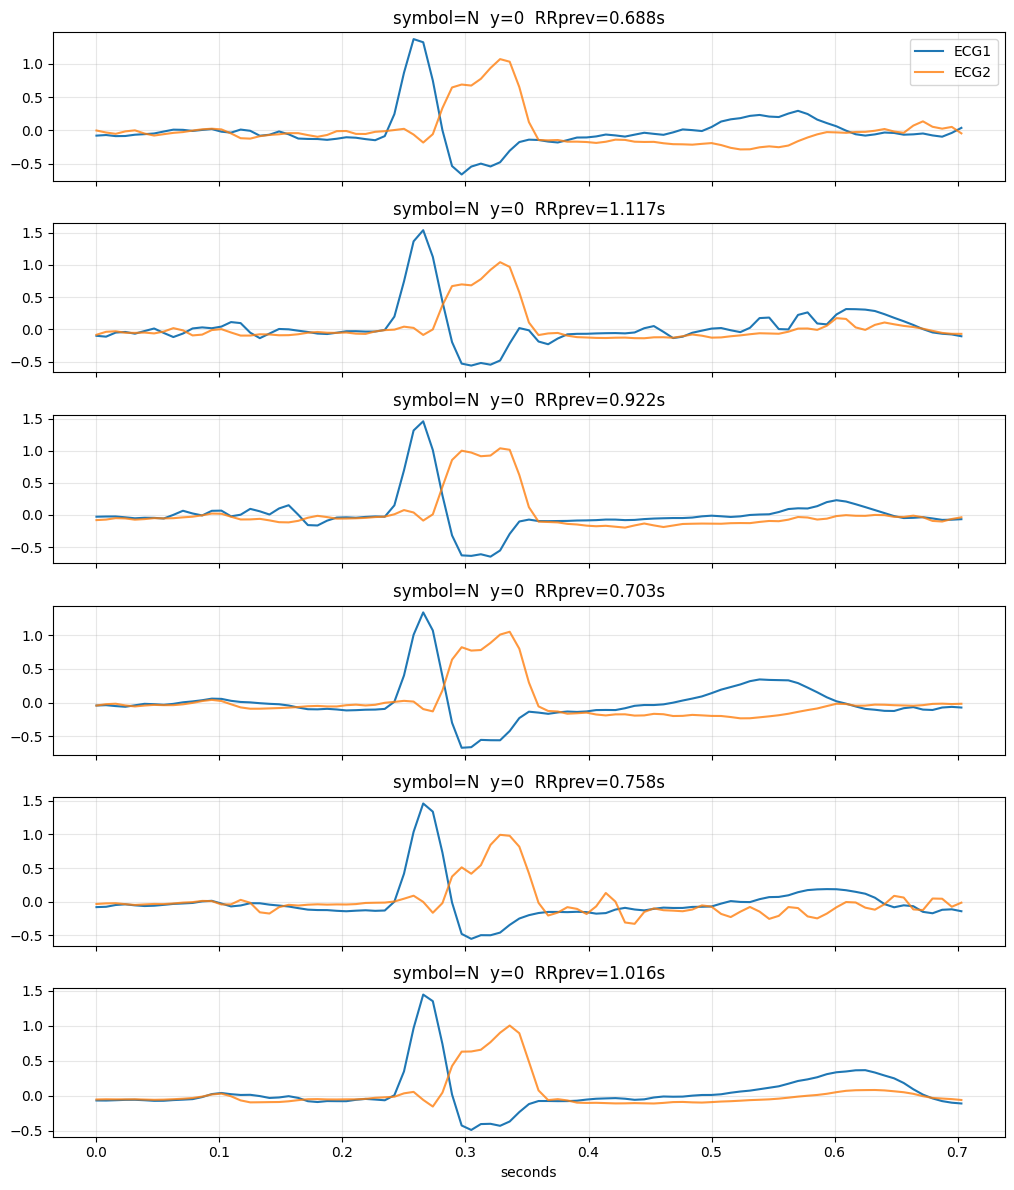

In [6]:
rng = np.random.default_rng(0)
idxs = rng.choice(len(X), size=min(6, len(X)), replace=False)
t = np.arange(L) / FS

fig, axes = plt.subplots(len(idxs), 1, figsize=(10, 2*len(idxs)), sharex=True)
if len(idxs) == 1: axes = [axes]
for ax, i in zip(axes, idxs):
    ax.plot(t, X[i,:,0], label=lead_cols[0])
    ax.plot(t, X[i,:,1], label=lead_cols[1], alpha=0.8)
    ax.set_title(f"symbol={y_sym[i]}  y={y[i]}  RRprev={R[i,0]:.3f}s")
    ax.grid(True, alpha=0.3)
axes[0].legend(loc="upper right")
plt.xlabel("seconds")
plt.tight_layout()
plt.show()


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_tmp, R_train, R_tmp, y_train, y_tmp = train_test_split(
    X, R, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, R_val, R_test, y_val, y_test = train_test_split(
    X_tmp, R_tmp, y_tmp, test_size=0.50, random_state=42, stratify=y_tmp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train pos:", y_train.sum(), "/", len(y_train))
print("Val   pos:", y_val.sum(), "/", len(y_val))
print("Test  pos:", y_test.sum(), "/", len(y_test))


Train: (1318, 91, 2) Val: (282, 91, 2) Test: (283, 91, 2)
Train pos: 21 / 1318
Val   pos: 4 / 282
Test  pos: 5 / 283


In [8]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {0: float(cw[0]), 1: float(cw[1])}

print("class_weight:", class_weight)


class_weight: {0: 0.5080956052428681, 1: 31.38095238095238}


In [9]:
from tensorflow import keras
from tensorflow.keras import layers

def build_cnn_with_rr(input_len, n_channels=2):
    x_in = keras.Input(shape=(input_len, n_channels), name="signal")
    x = layers.Conv1D(32, 7, padding="same", activation="relu")(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)

    x = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)

    x = layers.Conv1D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)

    rr_in = keras.Input(shape=(3,), name="rr")
    r = layers.Dense(16, activation="relu")(rr_in)
    r = layers.Dropout(0.2)(r)

    h = layers.Concatenate()([x, r])
    h = layers.Dense(64, activation="relu")(h)
    h = layers.Dropout(0.3)(h)
    out = layers.Dense(1, activation="sigmoid")(h)

    model = keras.Model(inputs=[x_in, rr_in], outputs=out)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.AUC(name="roc_auc", curve="ROC"),
            keras.metrics.AUC(name="pr_auc", curve="PR"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ],
    )
    return model

model = build_cnn_with_rr(input_len=L, n_channels=2)
model.summary()


2025-12-16 00:09:36.345645: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ signal (InputLayer) │ (None, 91, 2)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 91, 32)    │        480 │ signal[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 91, 32)    │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 45, 32)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 45, 64)    │     10,304 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 22, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 22, 128)   │     24,704 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 128)   │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rr (InputLayer)     │ (None, 3)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │         64 │ rr[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 144)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      9,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,793 (178.88 KB)

 Trainable params: 45,345 (177.13 KB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_pr_auc", mode="max", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_pr_auc", mode="max", patience=4, factor=0.5, min_lr=1e-5),
]

history = model.fit(
    {"signal": X_train, "rr": R_train}, y_train,
    validation_data=({"signal": X_val, "rr": R_val}, y_val),
    epochs=50,
    batch_size=64,
    class_weight=class_weight,
    verbose=1
)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.6002 - pr_auc: 0.2757 - precision: 0.0511 - recall: 0.5714 - roc_auc: 0.7509 - val_loss: 0.6122 - val_pr_auc: 0.5976 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.9964
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4350 - pr_auc: 0.4238 - precision: 0.0559 - recall: 0.9524 - roc_auc: 0.9363 - val_loss: 0.5877 - val_pr_auc: 0.5976 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.9964
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3193 - pr_auc: 0.6188 - precision: 0.1040 - recall: 0.8571 - roc_auc: 0.9683 - val_loss: 0.4856 - val_pr_auc: 0.5976 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.9964
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2796 - pr_auc: 0.4952 - precision: 0.0888 - recall: 0.9048 - roc_auc: 0.9629 - val_loss: 0.4726 - val_pr_auc: 0.5976 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

proba = model.predict({"signal": X_test, "rr": R_test}).ravel()

roc = roc_auc_score(y_test, proba) if len(np.unique(y_test)) > 1 else np.nan
pr  = average_precision_score(y_test, proba) if len(np.unique(y_test)) > 1 else np.nan
print("Test ROC-AUC:", roc)
print("Test PR-AUC :", pr)

prec, rec, thr = precision_recall_curve(y_test, proba)
f1s = 2*prec*rec / (prec+rec+1e-12)
best_i = np.argmax(f1s)

best_thr = thr[max(best_i-1, 0)] if len(thr) > 0 else 0.5
print("Best F1:", f1s[best_i], "at thr:", best_thr)

y_pred = (proba >= best_thr).astype(int)

print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1       :", f1_score(y_test, y_pred, zero_division=0))
print("\nReport:\n", classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test ROC-AUC: 0.9928057553956834
Test PR-AUC : 0.6787301587301586
Best F1: 0.7142857142852551 at thr: 0.07639464
Precision: 0.5
Recall   : 1.0
F1       : 0.6666666666666666

Report:
               precision    recall  f1-score   support

           0     1.0000    0.9820    0.9909       278
           1     0.5000    1.0000    0.6667         5

    accuracy                         0.9823       283
   macro avg     0.7500    0.9910    0.8288       283
weighted avg     0.9912    0.9823    0.9852       283

Confusion matrix:
 [[273   5]
 [  0   5]]


Target recall: 1.0 => (np.float32(0.2239684), np.float64(0.5555555555555556), np.float64(1.0))
Target recall: 0.9 => (np.float32(0.2239684), np.float64(0.5555555555555556), np.float64(1.0))
Target recall: 0.8 => (np.float32(0.40821746), np.float64(0.5714285714285714), np.float64(0.8))
Target recall: 0.7 => (np.float32(0.40821746), np.float64(0.5714285714285714), np.float64(0.8))


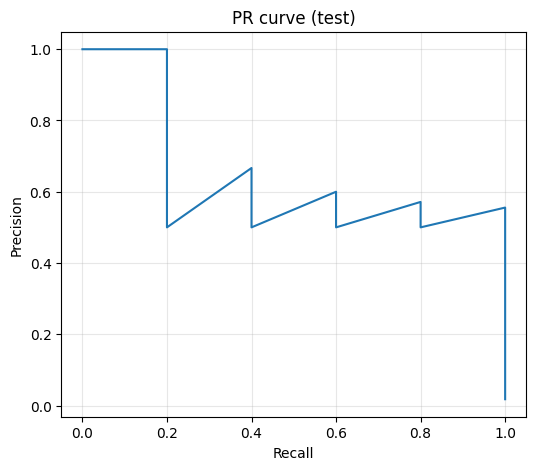

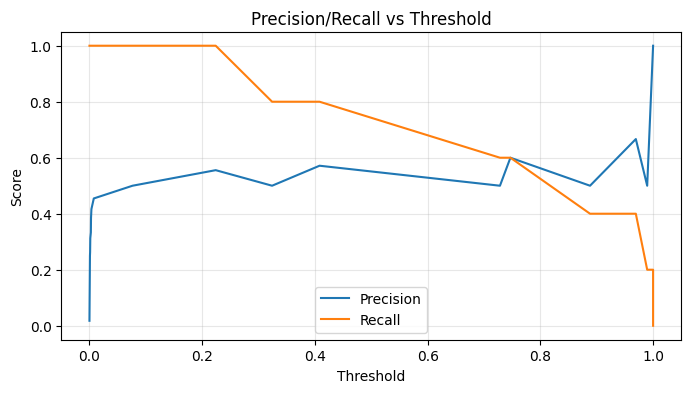

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test, proba)

# thr uzunluğu prec/rec'den 1 eksik olur, hizalamak için:
thr_full = np.r_[thr, thr[-1] if len(thr) else 0.5]

def best_threshold_min_recall(min_recall=0.9):
    mask = rec >= min_recall
    if not np.any(mask):
        return None
    # mask içindeki en yüksek precision'u seç
    i = np.argmax(np.where(mask, prec, -1))
    return thr_full[i], prec[i], rec[i]

for target_recall in [1.0, 0.9, 0.8, 0.7]:
    out = best_threshold_min_recall(target_recall)
    print("Target recall:", target_recall, "=>", out)

plt.figure(figsize=(6,5))
plt.plot(rec, prec)
plt.grid(True, alpha=0.3)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("PR curve (test)")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(thr_full, prec, label="Precision")
plt.plot(thr_full, rec, label="Recall")
plt.grid(True, alpha=0.3)
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.title("Precision/Recall vs Threshold")
plt.legend()
plt.show()


,loss,pr_auc,precision,recall,roc_auc,val_loss,val_pr_auc,val_precision,val_recall,val_roc_auc
45,0.003750,1.0,0.954545,1.0,1.0,0.018413,0.872294,0.800000,1.0,0.998201
46,0.004511,1.0,0.913043,1.0,1.0,0.029406,0.756714,0.666667,1.0,0.997752
47,0.003547,1.0,0.954545,1.0,1.0,0.014916,0.944214,0.800000,1.0,0.999101
48,0.002977,1.0,0.954545,1.0,1.0,0.010224,0.944214,0.800000,1.0,0.999101
49,0.001874,1.0,1.000000,1.0,1.0,0.008825,0.944214,0.800000,1.0,0.999101


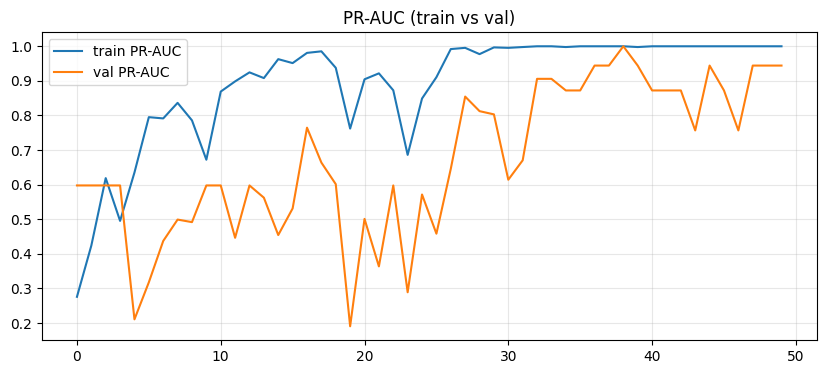

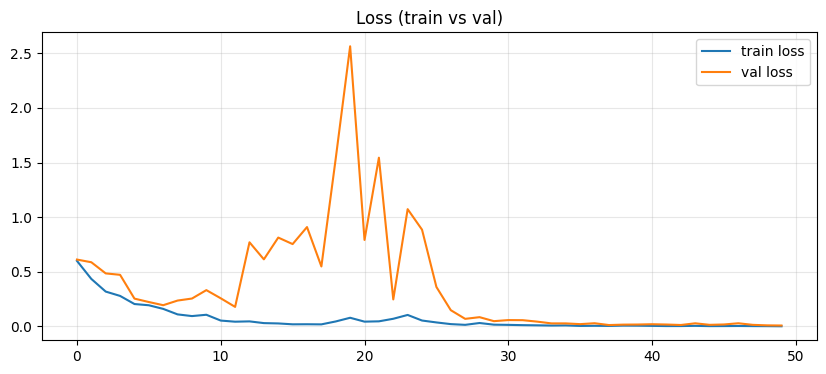

In [13]:
hist = pd.DataFrame(history.history)
display(hist.tail())

plt.figure(figsize=(10,4))
plt.plot(hist["pr_auc"], label="train PR-AUC")
plt.plot(hist["val_pr_auc"], label="val PR-AUC")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("PR-AUC (train vs val)")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(hist["loss"], label="train loss")
plt.plot(hist["val_loss"], label="val loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("Loss (train vs val)")
plt.show()


In [14]:
proba_tr = model.predict({"signal": X_train, "rr": R_train}).ravel()
roc_tr = roc_auc_score(y_train, proba_tr) if len(np.unique(y_train)) > 1 else np.nan
pr_tr  = average_precision_score(y_train, proba_tr) if len(np.unique(y_train)) > 1 else np.nan

proba_va = model.predict({"signal": X_val, "rr": R_val}).ravel()
roc_va = roc_auc_score(y_val, proba_va) if len(np.unique(y_val)) > 1 else np.nan
pr_va  = average_precision_score(y_val, proba_va) if len(np.unique(y_val)) > 1 else np.nan

print("Train ROC:", roc_tr, "Train PR:", pr_tr)
print("Val   ROC:", roc_va, "Val   PR:", pr_va)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train ROC: 1.0 Train PR: 1.0000000000000002
Val   ROC: 0.9991007194244604 Val   PR: 0.95
